# Quickstart

Let's walk through a simple example together!

## (1) Import all necessary libraries

Note: You need to compile the shared library before, see the Installation guide.

In [5]:
from IPython.display import clear_output


import sys
PATH_TO_AM3 = '/home/anni/Work/Software/AM3_Software/AM3_public_and_cleanup/AM3/'
sys.path.append(PATH_TO_AM3 + '/libpython/lib')
import pybind_AM3 as pb

# Also numpy and matplotlib for functionality
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors 

## (2) Pre-run definitions

### (2.1) Useful constants

In [6]:
# Some Constants, defining them here is a bit ugly, but might be needed for calculations
m_e_GeV = 0.511e-3 # GeV
m_e = 9. *10**(-28) # g
m_p = 0.938 # GeV
m_p_g = 1.67e-24
c0 = 3.0e10 #cm /s 
sigma_t = 0.665e-24 # cm2
e = 4.803e-10 # statC
erg_to_GeV = 624.15


### (2.2) Source and injection parameters

In [7]:
# SOURCE 
Radius = 1.e15
Bfield = 10.
Volume = 4/3.*np.pi *Radius**3

# ELECTRONS
Gamma_min_e = 2.e0# minimum Lorentz factor
Gamma_max_e = 1.e3
p_e = 1.9

I_inj_e = 10.0**(-7.47)
Pjet_e = I_inj_e * 4 * np.pi * Radius * m_e * c0**3 / sigma_t 

#PROTONS
Gamma_min_p = 2.e0
Gamma_max_p = 1.e8

I_inj_p = 10**(-4.93)
Pjet_p = I_inj_p * 4 * np.pi * Radius * m_p_g * c0**3 / sigma_t

p_p = 1.9

## (3) Initialisation

First we need to initialize the data arrays: 

In [8]:
dat = pb.AM3Arrays()
rp = pb.RunParams()

Then we pass the source and injection parameters:

In [9]:
rp.e_inj_Emin_eV = Gamma_min_e * m_e_GeV * 1.e9
rp.e_inj_Emax_eV =Gamma_max_e * m_e_GeV * 1.e9
rp.e_inj_index = p_e

rp.p_inj_Emin_eV = Gamma_min_p * m_p * 1.e9
rp.p_inj_Emax_eV = Gamma_max_p * m_p * 1.e9
rp.p_inj_index = p_p 

rp.p_in = Pjet_e / Volume
rp.FRACe = 1.0
rp.FRACp = Pjet_p / Pjet_e
rp.dt = 1.e-3 * Radius / c0
rp.B_co = Bfield
rp.t_esc = Radius/c0

Initialisation of physics modules:

In [10]:
ph = pb.PhysicsHandler(rp, dat)


Now comes the SimulationManager that will manage our run:
Initialise it, set the most important switches and 

In [11]:
# Set the simulation parameters (switches for processes on/ off)

sim= pb.SimulationManager(rp, ph)

sim.UpdateVerbosity(0) #set verbosity to 0

sim.process_in = 1 # internal injection: ON
sim.internal_inj_type = 1 #internal injection type: 1= power-law

sim.process_esy = 1 # electron synchrotron: ON
sim.process_psy= 1 # proton synchrotron: ON
sim.process_pisy = 0 # pion synchrotron: OFF
sim.process_musy = 0 # muon synchrotron: OFF

sim.process_eic = 1 # electron inverse Compton: ON
sim.process_pic = 1 # proton inverse Compton: ON
sim.process_piic = 0 # pion inverse Compton: OFF
sim.process_muic = 0 # muon inverse Compton: OFF

sim.process_sec_decay = 1 # decay of secondary particles: ON
sim.process_pair = 0 # gamma-gamma annihilation: OFF
sim.process_bh = 1 # photo-pair production (bethe heitler): ON
sim.process_pg = 1 # photo-pion production: ON

sim.process_es = 1 # escape: ON
sim.escape_type = 1 # escape type: 1 = free-streaming for all particles

sim.process_adi = 0 # adiabatic cooling: OFF
sim.process_exp = 0 # volume expansion term: OFF

sim.process_parse_sed = 1

Make sure it hase the correct magnetic field and calculate the kernels for the PDE

In [12]:
sim.Update_B(rp.B_co)
#Initialize Kernels
sim.InitKernels()

init. AM3 kernels:
AM3 has the following switches (at step: 0)
solver - ignoreCurrentLosses: 0
estimate maximum energies: 0
parse sed components: 1
internal injection: 1 ( power-law )
external injection: 0
escape: 1 ( free-streaming )
expansion: 0
adiabatic: 0
synchrotron:
  e+/-: 1  (rad.: 1, cool.: 1)
  protons:1  (rad.: 1, cool.: 1)
  pions:0  (rad.: 1, cool.: 1)
  muons:0  (rad.: 1, cool.: 1)
  syn-self-abs.:1
  quantum-syn.:0
inv. Compton:
  e+/-: 1  (rad. (full kernel): 1, cool.: 1 (continuous))
  photon loss due to upscattering: 1
  protons:1  (rad. (step approx.): 1, no cooling)
  pions:0  (rad. (step approx.): 1, cont. cool.: 1)
  muons:0  (rad. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)0  (photon loss.: 1, e+/- source (feedback): 1(full kernel))
secondary decay: 1 (pi: 1, mu:1)
proton Bethe-Heitler: 1  (rad.: 1  (full kernel), cool.: 1)
proton p-gamma: 1  (rad.: 1 (full kernel), cool.: 1, photon loss: 1)

AM3 params (comoving):
t_esc: 33333.3 s
t_expansi

Set all particle arrays to zero


In [13]:
# Clear all particles
sim.Clear_Particles()

Initialize the input-output class:

In [14]:
io = pb.IO(sim, rp, dat)

Define how long the run should be

In [16]:
times_tdyn = 8
t_run = 0.0

and run! 

In [17]:
while t_run < times_tdyn* rp.t_esc:
    clear_output(wait=True)
    sim.EvolveStep()
    t_run += rp.dt
    print(' percentage elapsed: ', t_run/(times_tdyn*rp.t_esc))

 percentage elapsed:  8.000000000000837


Read out Photons (by component) and Neutrinos

In [21]:
Gammas = io.Edn_dE_LepG()
Gammas_components = np.array([io.Edn_dE_LepG(), 
                              io.Edn_dE_LepG_insy(), io.Edn_dE_LepG_inic(), 
                              io.Edn_dE_LepG_bhsy(), io.Edn_dE_LepG_bhic(),
                              io.Edn_dE_LepG_pairsy(), io.Edn_dE_LepG_pairic(),
                              io.Edn_dE_LepG_pgsy(), io.Edn_dE_LepG_pgic(),
                              io.Edn_dE_LepG_psy(), io.Edn_dE_LepG_pic(),
                              io.Edn_dE_LepG_pi0()])
Neutrinos = io.Edn_dE_NU()


Grids

In [22]:
Grid_Gammas = io.E_LepG_eV()
Grid_Neutrinos = io.E_Nu_eV()


Plot! :)

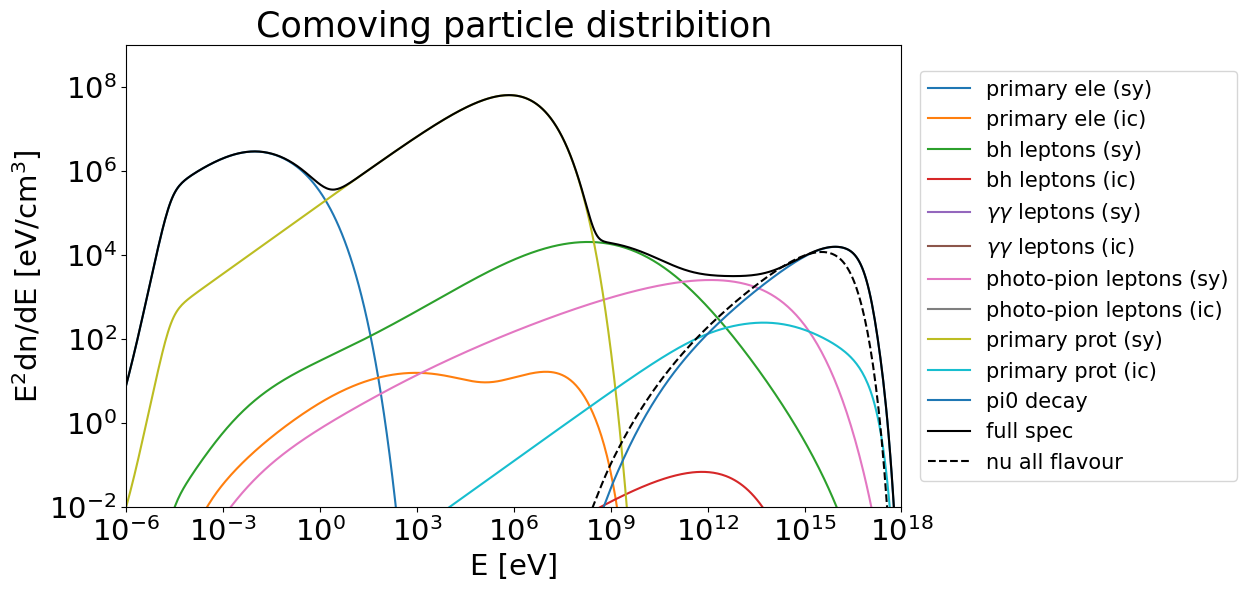

In [28]:
plt.figure(figsize = [10, 6])

ax = plt.gca()
matplotlib.rcParams.update({'font.size': 21})

names = ['full spec', 'primary ele (sy)', 'primary ele (ic)', 'bh leptons (sy)', 'bh leptons (ic)', r'$\gamma \gamma$ leptons (sy)', 
         r'$\gamma \gamma$ leptons (ic)', 'photo-pion leptons (sy)', 'photo-pion leptons (ic)', 'primary prot (sy)', 'primary prot (ic)','pi0 decay']

for i in range(len(Gammas_components)-1):
    ax.plot(Grid_Gammas, Gammas_components[i+1]*Grid_Gammas, alpha = 1.0, label = names[i+1])
    
i = 0
ax.plot(Grid_Gammas, Gammas_components[i]*Grid_Gammas, alpha = 1.0, label = names[i], color = 'k', ls = '-')
ax.plot(Grid_Neutrinos, Neutrinos*Grid_Neutrinos, alpha = 1.0, label = 'nu all flavour', color = 'k', ls = '--')

ax.set( 
        ylim = [1.e-2 ,1.e9], xlim = [1.e-6, 1.e18],
        xscale = 'log', yscale = 'log',
        xlabel = 'E [eV]', 
        ylabel = r'E$^2$dn/dE [eV/cm$^3$]',
        title = 'Comoving particle distribition'
       )

plt.legend(fontsize = 15, bbox_to_anchor = [1.01, 0.5], loc = 'center left')

plt.show()
